## 1. Tiền xử lý dữ liệu

In [1]:
import pandas as pd
import numpy as np

# Tải dữ liệu từ tệp CSV
df = pd.read_csv('./data/fitness_class_2212.csv')

# Xem thông tin cơ bản
print(df.head())
print(df.info())
print(df.describe(include='all'))
print("Giá trị duy nhất trong các cột:")
for col in df.columns:
    print(f"{col}: {df[col].unique()[:20]}") # In 20 giá trị duy nhất đầu tiên

   booking_id  months_as_member  weight days_before day_of_week time  \
0           1                17   79.56           8         Wed   PM   
1           2                10   79.01           2         Mon   AM   
2           3                16   74.53          14         Sun   AM   
3           4                 5   86.12          10         Fri   AM   
4           5                15   69.29           8         Thu   AM   

   category  attended  
0  Strength         0  
1      HIIT         0  
2  Strength         0  
3   Cycling         0  
4      HIIT         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-nul

In [2]:
df['attended'] = df['attended'].replace({'-0': 0, '1': 1, '0': 0}).astype(int)
print("Giá trị duy nhất trong 'attended' sau khi làm sạch:", df['attended'].unique())

Giá trị duy nhất trong 'attended' sau khi làm sạch: [0 1]


In [3]:
df['days_before'] = df['days_before'].astype(str).str.replace(r'\s*days?', '', regex=True).astype(int)
print("Kiểu dữ liệu của 'days_before' sau khi làm sạch:", df['days_before'].dtype)

Kiểu dữ liệu của 'days_before' sau khi làm sạch: int64


In [4]:
day_map = {
    'Wednesday': 'Wed', 'monday': 'Mon', 'Monday': 'Mon',
    'Fri.': 'Fri', 'Tue.': 'Tue' # Thêm các ánh xạ cần thiết khác
}
df['day_of_week'] = df['day_of_week'].replace(day_map)
# Đảm bảo tất cả các tên ngày đều được chuẩn hóa (ví dụ: viết hoa chữ cái đầu)
df['day_of_week'] = df['day_of_week'].str.capitalize()
print("Giá trị duy nhất trong 'day_of_week' sau khi làm sạch:", df['day_of_week'].unique())

Giá trị duy nhất trong 'day_of_week' sau khi làm sạch: ['Wed' 'Mon' 'Sun' 'Fri' 'Thu' 'Tue' 'Sat']


In [5]:
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
if df['weight'].isnull().sum() > 0:
    df['weight'] = df['weight'].fillna(df['weight'].median()) # Hoặc mean()
print(f"Số lượng giá trị thiếu trong 'weight' sau khi xử lý: {df['weight'].isnull().sum()}")

Số lượng giá trị thiếu trong 'weight' sau khi xử lý: 0


In [6]:
# Nếu '-' đại diện cho một loại không xác định hoặc thiếu, có thể thay thế bằng mode
# Hoặc giữ nguyên để LabelEncoder xử lý như một hạng mục riêng
if '-' in df['category'].unique():
    # Lựa chọn 1: Thay thế bằng mode
    # mode_category = df['category'].mode()[0]
    # df['category'] = df['category'].replace({'-': mode_category})
    # Lựa chọn 2: Để nguyên, LabelEncoder sẽ coi nó là một category
    pass
print("Giá trị duy nhất trong 'category' sau khi xem xét '-':", df['category'].unique())

Giá trị duy nhất trong 'category' sau khi xem xét '-': ['Strength' 'HIIT' 'Cycling' 'Yoga' '-' 'Aqua']


In [7]:
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['day_of_week', 'time', 'category']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str)) # Chuyển thành str để đảm bảo xử lý các giá trị không đồng nhất
    label_encoders[col] = le
print(df[categorical_cols].head())

   day_of_week  time  category
0            6     1         4
1            1     0         3
2            3     0         4
3            0     0         2
4            4     0         3


In [8]:
X = df.drop(['booking_id', 'attended'], axis=1)
y = df['attended']

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # random_state để có thể tái tạo, stratify để giữ tỷ lệ lớp

## 2. Huấn luyện và Đánh giá Mô hình (Trước SMOTE)

In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbosity=-1), # verbosity=-1 để ẩn warning
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm='SAMME'), # algorithm='SAMME' cho AdaBoost với target nhị phân khi base estimator không hỗ trợ predict_proba
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(random_state=42, probability=True), # probability=True để tính ROC AUC
    "Perceptron": Perceptron(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0) # verbose=0 để ẩn output khi huấn luyện
}

In [11]:
results_before_smote = {}
print("Kết quả trước SMOTE (Tái tạo Bảng 2):")
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Một số mô hình như Perceptron không có predict_proba mặc định
    if hasattr(clf, "predict_proba"):
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        # Đối với Perceptron, bạn có thể sử dụng decision_function nếu có, hoặc tính AUC dựa trên y_pred
        # Tuy nhiên, AUC thường được định nghĩa cho xác suất. Để đơn giản, có thể bỏ qua AUC hoặc chấp nhận nó không tối ưu.
        auc = np.nan # Hoặc tính dựa trên y_pred, nhưng sẽ không giống như paper

    results_before_smote[name] = {
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 score": f1_score(y_test, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": auc
    }
    print(f"{name}: {results_before_smote[name]}")

results_df_before_smote = pd.DataFrame(results_before_smote).T
print("\nBảng kết quả trước SMOTE:")
print(results_df_before_smote)

Kết quả trước SMOTE (Tái tạo Bảng 2):
Random Forest: {'Precision': 0.6428571428571429, 'Recall': 0.5934065934065934, 'F1 score': 0.6171428571428571, 'Accuracy': 0.7766666666666666, 'AUC': np.float64(0.7824280982175719)}
LightGBM: {'Precision': 0.5714285714285714, 'Recall': 0.5274725274725275, 'F1 score': 0.5485714285714286, 'Accuracy': 0.7366666666666667, 'AUC': np.float64(0.7635522372364477)}


/home/lamhung/miniconda3/envs/python3_10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:44:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: {'Precision': 0.5647058823529412, 'Recall': 0.5274725274725275, 'F1 score': 0.5454545454545454, 'Accuracy': 0.7333333333333333, 'AUC': np.float64(0.7561385982438614)}
KNN: {'Precision': 0.6190476190476191, 'Recall': 0.5714285714285714, 'F1 score': 0.5942857142857143, 'Accuracy': 0.7633333333333333, 'AUC': np.float64(0.744098007255902)}
Decision Tree: {'Precision': 0.4766355140186916, 'Recall': 0.5604395604395604, 'F1 score': 0.5151515151515151, 'Accuracy': 0.68, 'AUC': np.float64(0.6462484883537515)}
Gradient Boosting: {'Precision': 0.6111111111111112, 'Recall': 0.4835164835164835, 'F1 score': 0.5398773006134969, 'Accuracy': 0.75, 'AUC': np.float64(0.7964666912035333)}


/home/lamhung/miniconda3/envs/python3_10/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost: {'Precision': 0.6037735849056604, 'Recall': 0.7032967032967034, 'F1 score': 0.649746192893401, 'Accuracy': 0.77, 'AUC': np.float64(0.798228087701772)}
Naive Bayes: {'Precision': 0.7777777777777778, 'Recall': 0.46153846153846156, 'F1 score': 0.5793103448275863, 'Accuracy': 0.7966666666666666, 'AUC': np.float64(0.7867921552132078)}
Logistic Regression: {'Precision': 0.7719298245614035, 'Recall': 0.4835164835164835, 'F1 score': 0.5945945945945946, 'Accuracy': 0.8, 'AUC': np.float64(0.8188127661811873)}
SVM: {'Precision': 0.7954545454545454, 'Recall': 0.38461538461538464, 'F1 score': 0.5185185185185185, 'Accuracy': 0.7833333333333333, 'AUC': np.float64(0.8137388926862612)}
Perceptron: {'Precision': 0.4020100502512563, 'Recall': 0.8791208791208791, 'F1 score': 0.5517241379310345, 'Accuracy': 0.5666666666666667, 'AUC': nan}
CatBoost: {'Precision': 0.6455696202531646, 'Recall': 0.5604395604395604, 'F1 score': 0.6, 'Accuracy': 0.7733333333333333, 'AUC': np.float64(0.797045060202955)}

## 3. Cân bằng Dữ liệu với SMOTE và Huấn luyện lại

In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Kích thước tập huấn luyện sau SMOTE:", X_train_smote.shape, y_train_smote.shape)
print("Phân phối lớp trong tập huấn luyện sau SMOTE:\n", pd.Series(y_train_smote).value_counts())

Kích thước tập huấn luyện sau SMOTE: (1674, 6) (1674,)
Phân phối lớp trong tập huấn luyện sau SMOTE:
 attended
1    837
0    837
Name: count, dtype: int64


In [13]:
results_after_smote = {}
print("\nKết quả sau SMOTE (Tái tạo Bảng 3):")
for name, clf in classifiers.items(): # Sử dụng lại dictionary classifiers đã định nghĩa
    # Cần khởi tạo lại một số mô hình nếu chúng lưu trạng thái từ lần huấn luyện trước,
    # hoặc đảm bảo fit() sẽ ghi đè hoàn toàn. Scikit-learn thường làm vậy.
    # Đối với AdaBoost, nếu dùng SAMME, nó không hỗ trợ mẫu có giá trị 0, SMOTE có thể tạo ra giá trị gần 0.
    # Cần kiểm tra lại hoặc đảm bảo dữ liệu đầu vào phù hợp.
    try:
        if name == "AdaBoost": # AdaBoost với SAMME có thể nhạy cảm với dữ liệu từ SMOTE
            current_clf = AdaBoostClassifier(random_state=42) # Khởi tạo lại nếu cần
        else:
            current_clf = clf

        current_clf.fit(X_train_smote, y_train_smote)
        y_pred_smote = current_clf.predict(X_test) # Đánh giá trên X_test gốc

        if hasattr(current_clf, "predict_proba"):
            y_pred_proba_smote = current_clf.predict_proba(X_test)[:, 1]
            auc_smote = roc_auc_score(y_test, y_pred_proba_smote)
        else:
            auc_smote = np.nan

        results_after_smote[name] = {
            "Precision": precision_score(y_test, y_pred_smote, zero_division=0),
            "Recall": recall_score(y_test, y_pred_smote, zero_division=0),
            "F1 score": f1_score(y_test, y_pred_smote, zero_division=0),
            "Accuracy": accuracy_score(y_test, y_pred_smote),
            "AUC": auc_smote
        }
        print(f"{name}: {results_after_smote[name]}")
    except Exception as e:
        print(f"Lỗi khi huấn luyện {name} sau SMOTE: {e}")
        results_after_smote[name] = {"Precision": np.nan, "Recall": np.nan, "F1 score": np.nan, "Accuracy": np.nan, "AUC": np.nan}


results_df_after_smote = pd.DataFrame(results_after_smote).T
print("\nBảng kết quả sau SMOTE:")
print(results_df_after_smote)


Kết quả sau SMOTE (Tái tạo Bảng 3):
Random Forest: {'Precision': 0.5327868852459017, 'Recall': 0.7142857142857143, 'F1 score': 0.6103286384976526, 'Accuracy': 0.7233333333333334, 'AUC': np.float64(0.7668384247331615)}
LightGBM: {'Precision': 0.5585585585585585, 'Recall': 0.6813186813186813, 'F1 score': 0.6138613861386139, 'Accuracy': 0.74, 'AUC': np.float64(0.7699142962300857)}
XGBoost: {'Precision': 0.5043478260869565, 'Recall': 0.6373626373626373, 'F1 score': 0.5631067961165048, 'Accuracy': 0.7, 'AUC': np.float64(0.7615016562384984)}
KNN: {'Precision': 0.48854961832061067, 'Recall': 0.7032967032967034, 'F1 score': 0.5765765765765766, 'Accuracy': 0.6866666666666666, 'AUC': np.float64(0.7098164992901835)}
Decision Tree: {'Precision': 0.4649122807017544, 'Recall': 0.5824175824175825, 'F1 score': 0.5170731707317073, 'Accuracy': 0.67, 'AUC': np.float64(0.6452757768547243)}


/home/lamhung/miniconda3/envs/python3_10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:44:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Gradient Boosting: {'Precision': 0.5076923076923077, 'Recall': 0.7252747252747253, 'F1 score': 0.5972850678733032, 'Accuracy': 0.7033333333333334, 'AUC': np.float64(0.7957305852042694)}
AdaBoost: {'Precision': 0.5426356589147286, 'Recall': 0.7692307692307693, 'F1 score': 0.6363636363636364, 'Accuracy': 0.7333333333333333, 'AUC': np.float64(0.8182606866817393)}
Naive Bayes: {'Precision': 0.57, 'Recall': 0.6263736263736264, 'F1 score': 0.5968586387434555, 'Accuracy': 0.7433333333333333, 'AUC': np.float64(0.7850044692149954)}
Logistic Regression: {'Precision': 0.543859649122807, 'Recall': 0.6813186813186813, 'F1 score': 0.6048780487804878, 'Accuracy': 0.73, 'AUC': np.float64(0.8190230821809769)}
SVM: {'Precision': 0.5752212389380531, 'Recall': 0.7142857142857143, 'F1 score': 0.6372549019607843, 'Accuracy': 0.7533333333333333, 'AUC': np.float64(0.8168673431831327)}
Perceptron: {'Precision': 0.6, 'Recall': 0.6923076923076923, 'F1 score': 0.6428571428571429, 'Accuracy': 0.7666666666666667, '

## 4. Vẽ Đường cong ROC

/home/lamhung/miniconda3/envs/python3_10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:44:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/lamhung/miniconda3/envs/python3_10/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


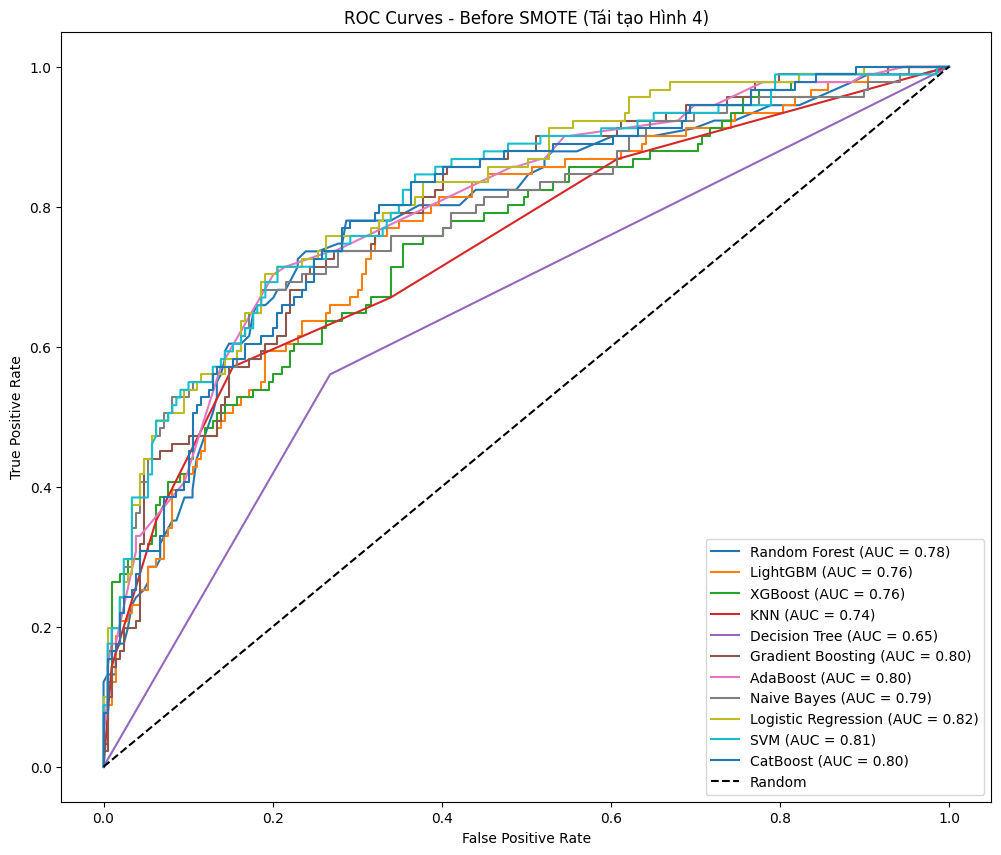

/home/lamhung/miniconda3/envs/python3_10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:44:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


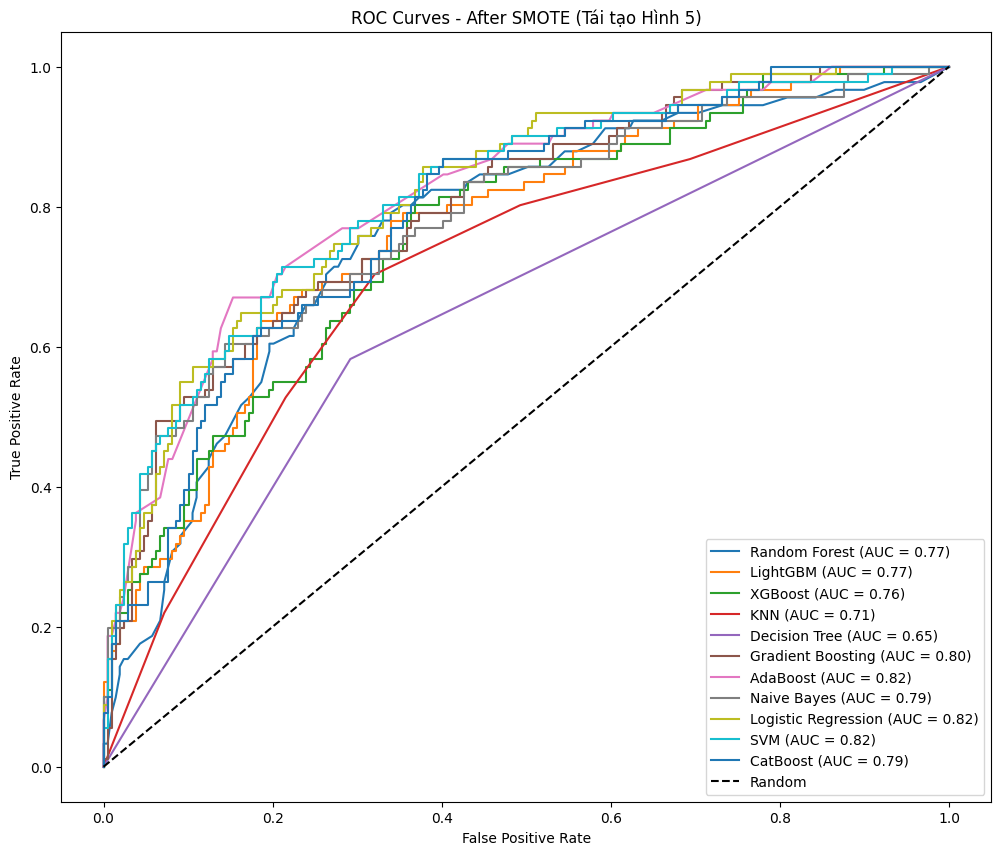

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(12, 10))
# Trước SMOTE
for name, clf_result in results_before_smote.items():
    # Lấy lại mô hình đã huấn luyện hoặc huấn luyện lại nếu cần
    # Đoạn mã này giả định bạn đã lưu trữ mô hình hoặc sẽ huấn luyện lại
    # Để đơn giản, tôi sẽ huấn luyện lại ở đây, nhưng trong thực tế, bạn nên lưu mô hình
    current_clf = classifiers[name] # Lấy mô hình chưa huấn luyện
    current_clf.fit(X_train, y_train) # Huấn luyện trên dữ liệu gốc
    if hasattr(current_clf, "predict_proba"):
        y_pred_proba = current_clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_val = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Before SMOTE (Tái tạo Hình 4)')
plt.legend()
plt.show()


plt.figure(figsize=(12, 10))
# Sau SMOTE
for name, clf_result in results_after_smote.items():
    current_clf = classifiers[name]
    # Đảm bảo AdaBoost được khởi tạo lại nếu có vấn đề
    if name == "AdaBoost":
        current_clf = AdaBoostClassifier(random_state=42)

    try:
        current_clf.fit(X_train_smote, y_train_smote)
        if hasattr(current_clf, "predict_proba"):
            y_pred_proba_smote = current_clf.predict_proba(X_test)[:, 1]
            fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)
            auc_val_smote = roc_auc_score(y_test, y_pred_proba_smote)
            plt.plot(fpr_smote, tpr_smote, label=f'{name} (AUC = {auc_val_smote:.2f})')
    except Exception as e:
        print(f"Không thể vẽ ROC cho {name} sau SMOTE: {e}")


plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - After SMOTE (Tái tạo Hình 5)')
plt.legend()
plt.show()

## 5. Trí tuệ Nhân tạo Có thể Giải thích (XAI) với LIME và SHAP

In [15]:
best_model_rf = RandomForestClassifier(random_state=42)
best_model_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [16]:
import lime
import lime.lime_tabular

# Tạo explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_smote.values, # LIME cần numpy array
    feature_names=X_train_smote.columns.tolist(),
    class_names=['Not Attended', 'Attended'],
    mode='classification'
)

# Chọn một mẫu từ tập kiểm tra để giải thích
instance_idx = 0 # Chọn mẫu đầu tiên hoặc một mẫu cụ thể
instance = X_test.iloc[[instance_idx]]

# Lấy giải thích
# predict_proba của Random Forest trả về xác suất cho cả hai lớp
explanation_lime = explainer_lime.explain_instance(
    data_row=instance.values.ravel(), # Cần 1D array
    predict_fn=best_model_rf.predict_proba
)

# Hiển thị giải thích (trong notebook hoặc lưu thành file)
explanation_lime.show_in_notebook(show_table=True, show_all=False)
# Hoặc lưu thành HTML
# explanation_lime.save_to_file(f'lime_explanation_instance_{instance_idx}.html')
print(f"Giải thích LIME cho mẫu {instance_idx}: Dự đoán của mô hình: {best_model_rf.predict(instance)[0]}, Xác suất dự đoán: {best_model_rf.predict_proba(instance)}")

/home/lamhung/miniconda3/envs/python3_10/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Giải thích LIME cho mẫu 0: Dự đoán của mô hình: 0, Xác suất dự đoán: [[0.95 0.05]]
